In [1]:
from fastcore.basics import store_attr
from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos
from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize, ColSplitter, RandomSplitter
from fastai.layers import Mish
from fastai.losses import FocalLossFlat
from fastai.losses import DiceLoss
from fastai.optimizer import ranger
from fastai.torch_core import tensor
from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats, SegmentationDataLoaders
from fastai.vision.learner import unet_learner
from PIL import Image
import numpy as np
from torch import nn
from torchvision.models.resnet import resnet34
import torch
import torch.nn.functional as F
from pandas import DataFrame, read_csv
from torch import Tensor
from functools import partial


from fastai.losses import FocalLoss as FL

def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))

In [2]:
import torch.cuda
torch.cuda.is_available()

torch.cuda.current_device()
torch.cuda.device(0)
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2070'

<AxesSubplot:>

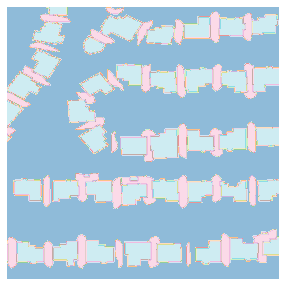

In [3]:
msk = PILMask.create('/home/stephen/AwsMLHack/data/processed/mask/AOI_2_Vegas_img225.png')
msk.show()

In [4]:

tensor(msk)
np.unique(msk)

array([0, 1, 2, 3], dtype=uint8)

In [5]:
fnames = get_image_files('/home/stephen/AwsMLHack/data/processed/img/')


def label_func(x:Path):
    return "/home/stephen/AwsMLHack/data/processed/mask/" + x.stem + ".png"

augs = [*aug_transforms(do_flip=False,flip_vert=False,max_rotate=0,max_zoom=1.3,
                                                  size=(360,360),)]


dls = SegmentationDataLoaders.from_label_func(path='/home/stephen/AwsMLHack/data/processed/img/',
                                              fnames=fnames,
                                              label_func=label_func,seed=42,
                                              batch_tfms=augs,bs=6,codes=["background","border","intersect","outline"]


)


/home/stephen/anaconda3/envs/condaenvtest/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/home/stephen/anaconda3/envs/condaenvtest/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered interna

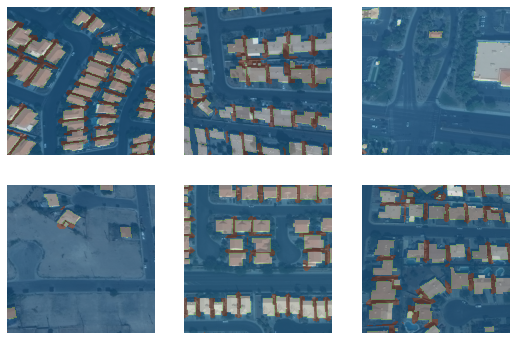

In [6]:
dls.show_batch(max_n=9)
batch = dls.one_batch()

<AxesSubplot:>

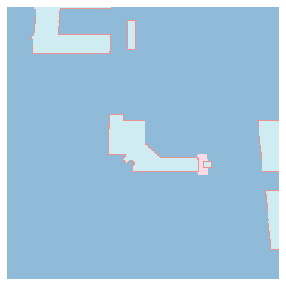

In [16]:
batch[1][1].show()

<AxesSubplot:>

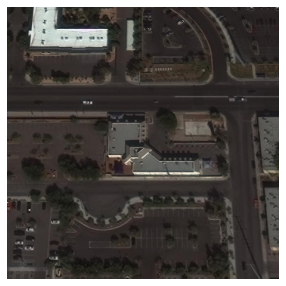

In [17]:
batch[0][1].show()

In [18]:
print (batch[0].size())
print(batch[1].size())

torch.Size([6, 3, 360, 360])
torch.Size([6, 360, 360])


In [19]:
class CombinedLoss:
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1., alpha=1.,gamma=3):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis,gamma=gamma)
        self.dice_loss =  DiceLoss(axis, smooth)

    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)

    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

SuggestedLRs(valley=4.365158383734524e-05)

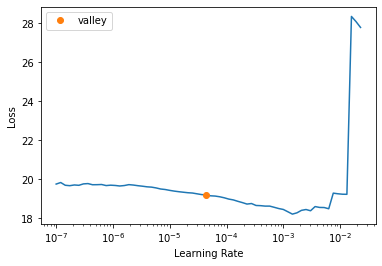

In [21]:
learn = unet_learner(dls,resnet34,self_attention=True,
                     loss_func=CombinedLoss())

learn.lr_find()

In [22]:
learn.fit_one_cycle(5,0.0001)

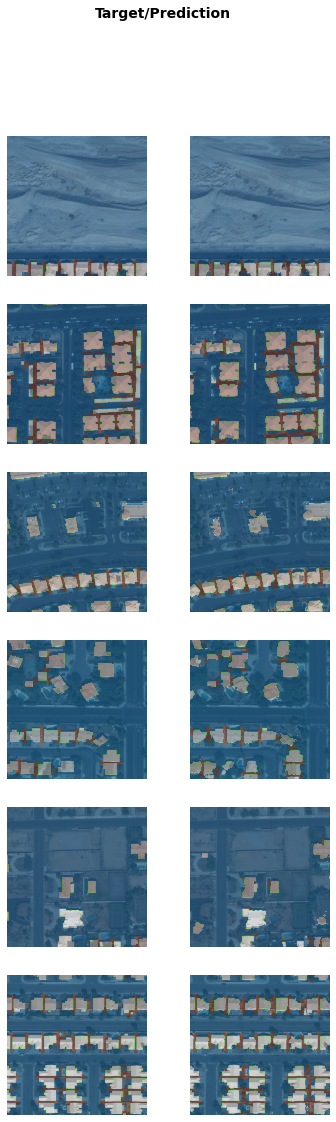

In [23]:
learn.show_results()

In [24]:
learn.save('new-stage-1')

Path('/home/stephen/AwsMLHack/data/processed/img/models/stage-1.pth')

In [25]:
learn.unfreeze()

In [26]:
learn.fit_one_cycle(10,0.001)

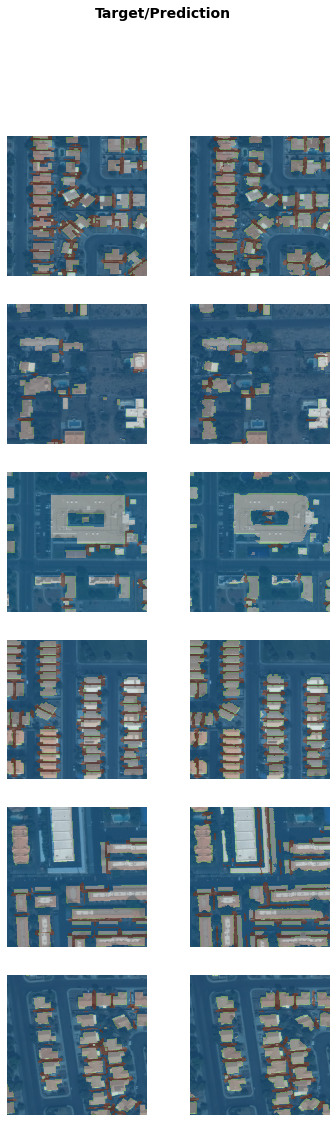

In [31]:
learn.show_results()

In [13]:
learn.save('new-stage-2')

Path('/home/stephen/AwsMLHack/data/processed/img/models/stage-2.pth')